In [1]:
import sys
import clipboard
import gc
import PIL, numpy as np, cv2
from PIL.ImageGrab import grab as screenshot
if "mycvtools" in sys.modules:
    del sys.modules["mycvtools"]
    gc.collect()
sys.path.append('C:\\Users\\Administrator\\source\\repos\\mycvtools\\x64\\Release\\')
import mycvtools
import importlib

In [11]:
ss = screenshot((500, 500, 800, 600))
ssa = np.array(ss)

In [3]:
mask = mycvtools.mask_grayscale(ssa)

In [4]:
mask[0][0], mask[0][1], mask[1][0]

(0, 0, 0)

In [5]:
ssa[0][0], ssa[0][1], ssa[1][0]

(array([39, 40, 34], dtype=uint8),
 array([39, 40, 34], dtype=uint8),
 array([39, 40, 34], dtype=uint8))

In [9]:
ssa[np.where(1-mask)] = 255

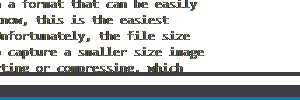

In [10]:
PIL.Image.fromarray(ssa)

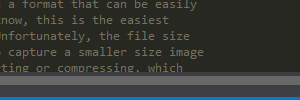

In [12]:
ss2 = ss.copy()
ss2

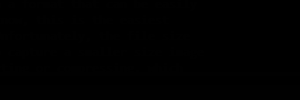

In [8]:
ss2.paste(PIL.Image.fromarray(mask))
ss2

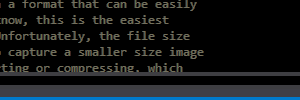

In [26]:
new = PIL.Image.fromarray(np.zeros_like(ss2))
imask = PIL.Image.fromarray(mask*255)
new.paste(ss2, (0,0), imask)
new

In [23]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)